# Setup

In [78]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import RMSprop, Adagrad, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from pprint import pprint

# MNIST

In [2]:
# Reference architecture from
# https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512 # hyperparameter
batch_size = 100
latent_dim = 2 # hyperparameter
epochs = 50

In [83]:
print(len(x_train))
print(x_train.shape)
print(len(x_test))
print(x_test.shape)

60000
(60000, 784)
10000
(10000, 784)


In [5]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape)
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [7]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [8]:
# encoder, from inputs to latent space
encoder = Model(inputs, [z_mean, z_log_sigma, z])

In [9]:
# build decorder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [10]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs)

In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [12]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
model_2 (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [13]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

sgd = SGD()
adam = Adam()
vae.add_loss(vae_loss)
vae.compile(optimizer=adam)

# Training

Train our VAE on MNIST digits.

In [16]:
vae_hist = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 37s 612us/step - loss: 162.6197 - val_loss: 162.1081
Epoch 2/50
60000/60000 [==============================] - 36s 597us/step - loss: 161.1554 - val_loss: 160.6469
Epoch 3/50
60000/60000 [==============================] - 35s 581us/step - loss: 159.6648 - val_loss: 159.3382
Epoch 4/50
60000/60000 [==============================] - 36s 605us/step - loss: 158.3466 - val_loss: 158.2816
Epoch 5/50
60000/60000 [==============================] - 37s 610us/step - loss: 157.2585 - val_loss: 157.2018
Epoch 6/50
60000/60000 [==============================] - 35s 589us/step - loss: 156.3561 - val_loss: 156.4402
Epoch 7/50
60000/60000 [==============================] - 36s 604us/step - loss: 155.5583 - val_loss: 155.7427
Epoch 8/50
60000/60000 [==============================] - 37s 613us/step - loss: 154.8576 - val_loss: 155.0281
Epoch 9/50
60000/60000 [==============================] - 38s 

In [17]:
# save model
vae.save("./runs/vae.h5")

In [18]:
vae_hist = vae_hist.history

In [19]:
# save history
with open('./runs/vae.hist', 'w', encoding="utf-8") as fout:
    pprint(vae_hist, fout)

In [20]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="train")
    plt.plot(iterations, test, label="test")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

# Loss graph

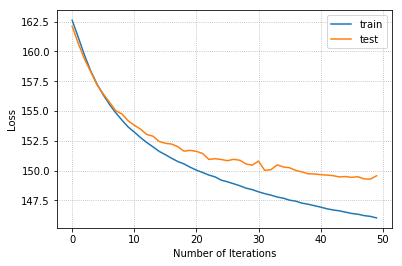

In [21]:
# show loss graph
plotLoss(vae_hist['loss'], vae_hist['val_loss'])

# Photo gallery

In [22]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)

In [67]:
def photogallery(photos):
    fig = plt.figure(figsize=(4, 12))
    for i, entry in enumerate(photos):
        ax1 = fig.add_subplot(10,2,i*2+1)
        ax1.imshow(entry[0], cmap=plt.cm.gray)
        ax2 = fig.add_subplot(10,2,i*2+2)
        ax2.imshow(entry[1], cmap=plt.cm.gray)

original, vae


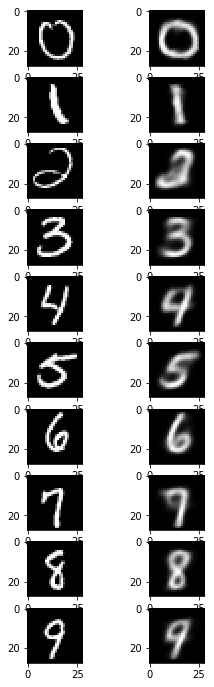

In [68]:
np.random.seed(42)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
photos = []

print("original, vae")
for digit in digits:
    index0 = np.where(y_test==digit)[0]
    pick = index0[np.random.choice(index0.shape[0])]
    #digit_indexes.append(pick)
    #print(pick)

    original = x_test[pick].reshape(image_size, image_size)
    encoded = x_test_encoded[pick].reshape(image_size, image_size)
    photos.append([original, encoded])
    
photogallery(photos)

In [ ]:
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.savefig('cifar_vae_mean.pdf')
plt.show()

# Hyperparameter tuning

In [69]:
# try different latent dimension and intermediate dimension, compare losses
# build model to reuse with several experiments

In [70]:
def vae_model(latent_dim=2, intermediate_dim=512):
    # VAE model = encoder + decoder
    # build encoder model
    print("latent_dim: ", latent_dim)
    print("intermediate_dim: ", intermediate_dim)
    inputs = Input(shape=input_shape)
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # z = z_mean + sqrt(var)*eps
    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments:
            args (tensor): mean and log of variance of Q(z|X)
        # Returns:
            z (tensor): sampled latent vector
        """

        z_mean, z_log_sigma = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    # encoder, from inputs to latent space
    encoder = Model(inputs, [z_mean, z_log_sigma, z])

    # build decorder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs)

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs)
    
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    sgd = SGD()
    adam = Adam()
    vae.add_loss(vae_loss)
    vae.compile(optimizer=adam)

    return vae

In [72]:
# try different latent_dim
latent_dims = [5,10]

for latent_dim in latent_dims:
    vae_mdl = vae_model(latent_dim=latent_dim)
    vae_hist = vae_mdl.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    
    # save model
    vae_mdl.save('./runs/vae_intermediate_512_latent_'+str(latent_dim)+'.h5')
    
    # save history
    with open('./runs/vae_intermediate_512_latent_'+str(latent_dim)+'.hist', 'w', encoding="utf-8") as fout:
        pprint(vae_hist.history, fout)

latent_dim:  5
intermediate_dim:  512
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 35s 585us/step - loss: 168.3792 - val_loss: 142.2286
Epoch 2/50
60000/60000 [==============================] - 30s 504us/step - loss: 139.3250 - val_loss: 136.1508
Epoch 3/50
60000/60000 [==============================] - 30s 497us/step - loss: 135.1586 - val_loss: 133.1762
Epoch 4/50
60000/60000 [==============================] - 29s 478us/step - loss: 132.8747 - val_loss: 131.5768
Epoch 5/50
60000/60000 [==============================] - 29s 480us/step - loss: 131.2656 - val_loss: 130.2913
Epoch 6/50
60000/60000 [==============================] - 29s 481us/step - loss: 129.9778 - val_loss: 129.2677
Epoch 7/50
60000/60000 [==============================] - 28s 471us/step - loss: 128.8819 - val_loss: 128.1248
Epoch 8/50
60000/60000 [==============================] - 29s 491us/step - loss: 127.9365 - val_loss: 127.3384
Epoch 9/50
60000/60000 [

60000/60000 [==============================] - 18s 303us/step - loss: 106.2340 - val_loss: 106.2202
Epoch 23/50
60000/60000 [==============================] - 18s 301us/step - loss: 106.0095 - val_loss: 106.2407
Epoch 24/50
60000/60000 [==============================] - 18s 300us/step - loss: 105.8064 - val_loss: 105.8542
Epoch 25/50
60000/60000 [==============================] - 18s 298us/step - loss: 105.6747 - val_loss: 105.9508
Epoch 26/50
60000/60000 [==============================] - 18s 298us/step - loss: 105.5710 - val_loss: 105.7663
Epoch 27/50
60000/60000 [==============================] - 18s 302us/step - loss: 105.3774 - val_loss: 105.6330
Epoch 28/50
60000/60000 [==============================] - 18s 302us/step - loss: 105.2338 - val_loss: 105.4973
Epoch 29/50
60000/60000 [==============================] - 18s 298us/step - loss: 105.0890 - val_loss: 105.5452
Epoch 30/50
60000/60000 [==============================] - 18s 301us/step - loss: 104.9554 - val_loss: 105.3635
Epoc

In [73]:
# read history from file
with open('./runs/vae_intermediate_512_latent_5.hist', 'r', encoding="utf-8") as fin:
    vae_hist = eval(fin.read())

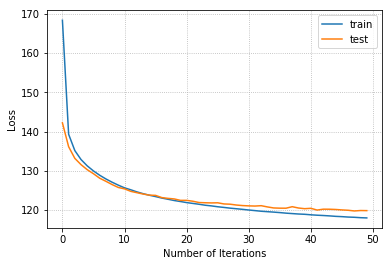

In [74]:
plotLoss(vae_hist['loss'], vae_hist['val_loss'])

In [75]:
# read history from file
with open('./runs/vae_intermediate_512_latent_10.hist', 'r', encoding="utf-8") as fin:
    vae_hist = eval(fin.read())

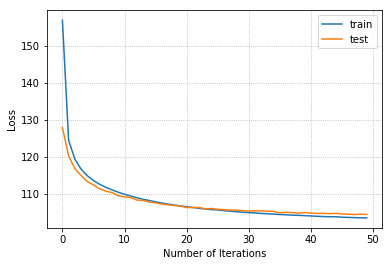

In [76]:
plotLoss(vae_hist['loss'], vae_hist['val_loss'])

In [80]:
# load model
#model = load_model('./runs/vae_intermediate_512_latent_10.h5')

latent: 10, intermediate: 512
original, vae


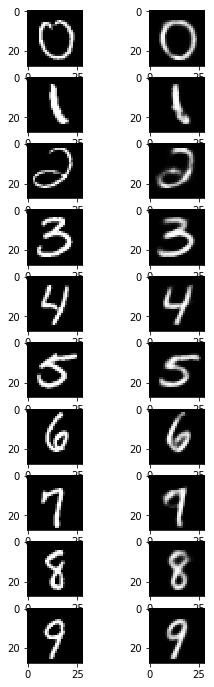

In [82]:
x_test_encoded = vae_mdl.predict(x_test, batch_size=batch_size)

np.random.seed(42)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
photos = []

print("latent: 10, intermediate: 512")
print("original, vae")
for digit in digits:
    index0 = np.where(y_test==digit)[0]
    pick = index0[np.random.choice(index0.shape[0])]
    #digit_indexes.append(pick)
    #print(pick)

    original = x_test[pick].reshape(image_size, image_size)
    encoded = x_test_encoded[pick].reshape(image_size, image_size)
    photos.append([original, encoded])
    
photogallery(photos)

In [ ]:
# decide on best latent_dim
# try different intermediate_dim
intermediate_dims = [256,1024]
models = []
for intermediate_dim in intermediate_dims:
    vae_mdl = vae_model(latent_dim=10, intermediate_dim=intermediate_dim)
    vae_hist = vae_mdl.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    
    # save model
    models.append(vae_mdl)
    #vae_mdl.save('./runs/vae_intermediate_'+str(intermediate_dim)+'_latent_xxx.h5')
    
    # save history
    with open('./runs/vae_intermediate_'+str(intermediate_dim)+'_latent_10.hist', 'w', encoding="utf-8") as fout:
        pprint(vae_hist.history, fout)
        
#vae_model = vae_model(latent_dim=, intermediate_dim=256)
#vae_model = vae_model(latent_dim=, intermediate_dim=512)
#vae_model = vae_model(latent_dim=, intermediate_dim=1024)

# CIFAR-10